<a href="https://colab.research.google.com/github/zar7364/DataScience/blob/main/Pyspark_Test_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#https://www.kaggle.com/utcarshagrawal/water-quality-prediction-using-sparkml

import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import udf, concat, col, lit
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

In [15]:
from google.colab import drive

In [16]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
data_csv=('/content/drive/My Drive/Colab Notebooks/SparkML/waterquality.csv')
data_shp=('/content/drive/My Drive/Colab Notebooks/SparkML/Indian_States.shp')

In [18]:
df = spark.read.format("csv").option("header", "true").load(data_csv)
gdf = gpd.read_file(data_shp)

In [19]:
df.show()

+------------+--------------------+--------------+----+---+---+------------+----+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|         STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+--------------+----+---+---+------------+----+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|   MAHARASHTRA|29.2|6.4|8.1|         735| 3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|   MAHARASHTRA|24.5|  6|  8|         270| 3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|   MAHARASHTRA|25.8|5.5|7.8|         355| 4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|   MAHARASHTRA|24.8|5.5|7.8|         371| 5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|   MAHARASHTRA|25.7|5.7|7.9|         294|

In [ ]:
gdf

In [21]:
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'string'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [24]:
#Data Cleaning
from pyspark.sql.types import FloatType

In [36]:
df=df.withColumn("TEMP",df["TEMP"].cast(FloatType()))
df=df.withColumn("DO",df["DO"].cast(FloatType()))
df=df.withColumn("pH",df["pH"].cast(FloatType()))
df=df.withColumn("CONDUCTIVITY",df["CONDUCTIVITY"].cast(FloatType()))
df=df.withColumn("BOD",df["BOD"].cast(FloatType()))
df=df.withColumn("NITRATE_N_NITRITE_N",df["NITRATE_N_NITRITE_N"].cast(FloatType()))
df=df.withColumn("FECAL_COLIFORM",df["FECAL_COLIFORM"].cast(FloatType()))
df=df.withColumn("TOTAL_COLIFORM",df["TOTAL_COLIFORM"].cast(FloatType()))
df.dtypes

[('STATION CODE', 'string'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'float')]

In [50]:
df=df.drop("TOTAL_COLIFORM")

In [54]:
#Probably this using NoSQL because using df.head() shows MongoDB view
df.show()

+------------+--------------------+--------------+----+---+---+------------+----+-------------------+--------------+
|STATION CODE|           LOCATIONS|         STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+--------------------+--------------+----+---+---+------------+----+-------------------+--------------+
|        1312|GODAVARI AT JAYAK...|   MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0|
|        2177|GODAVARI RIVER NE...|   MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0|
|        2182|GODAVARI RIVER AT...|   MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0|
|        2179|GODAVARI RIVER AT...|   MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|          90.0|
|        2183|GODAVARI RIVER AT...|   MAHARASHTRA|25.7|5.7|7.9|       294.0| 3.2|               2.69|          45.0|
|        2181|GODAVARI RIVER AT...|   MAHARASHTRA|25.0|4.5|7.5| 

In [62]:
#Now we want to remove all the rows which contain any null value in it. So for applying a SQL query we first have to register it has a virtual temporary table and then we will issue SQL query. We are doing this because it is important to perform data cleansing steps as it will make our model to work better.
df.createOrReplaceTempView("df_sql")

In [63]:
df_clean=spark.sql('''SELECT * FROM df_sql where
TEMP is not null and 
DO is not null and 
pH is not null and 
BOD is not null and 
CONDUCTIVITY is not null and 
NITRATE_N_NITRITE_N is not null and 
FECAL_COLIFORM is not null''')

In [64]:
df_clean.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0|4.2|                9.0|          59.0|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0|5.6|               3.55|          90.0|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|       294.0|3.2|               2.69|          45.0|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------

In [65]:
#EDA
df_clean.createOrReplaceTempView("df_sql")

In [66]:
do = spark.sql("Select DO from df_sql")
do = do.rdd.map(lambda row : row.DO).collect()
ph = spark.sql("Select pH from df_sql")
ph = ph.rdd.map(lambda row : row.pH).collect()
bod = spark.sql("Select BOD from df_sql")
bod = bod.rdd.map(lambda row : row.BOD).collect()
nn = spark.sql("Select NITRATE_N_NITRITE_N from df_sql")
nn = nn.rdd.map(lambda row : row.NITRATE_N_NITRITE_N).collect()

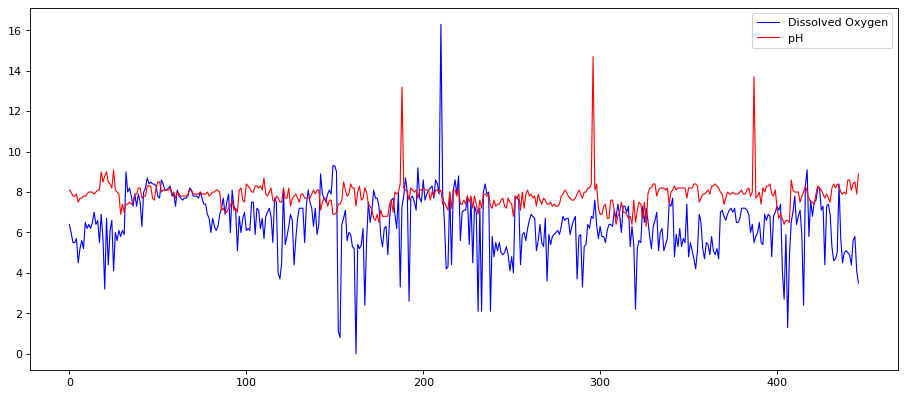

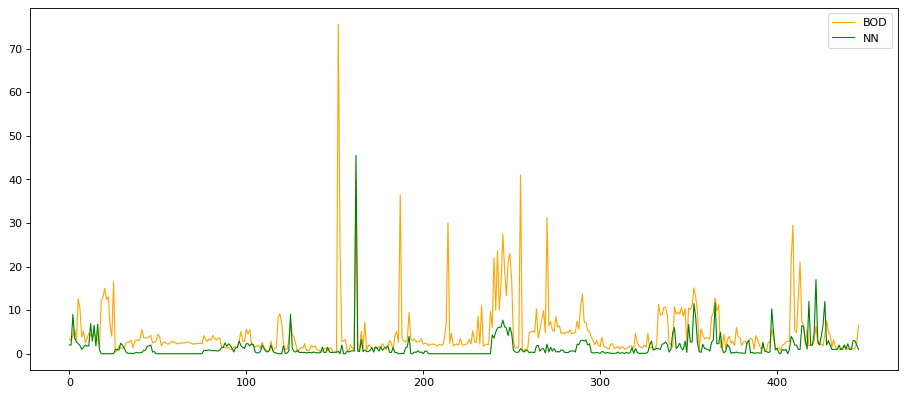

In [67]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
size=len(do)
ax.plot(range(0,size), do, color='blue', animated=True, linewidth=1, label='Dissolved Oxygen')
ax.plot(range(0,size), ph, color='red', animated=True, linewidth=1, label='pH')
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), bod, color='orange', animated=True, linewidth=1, label='BOD')
ax2.plot(range(0,size), nn, color='green', animated=True, linewidth=1, label='NN')
legend=ax.legend()
legend=ax2.legend()

In [68]:


con = spark.sql("Select CONDUCTIVITY from df_sql")
con = con.rdd.map(lambda row : row.CONDUCTIVITY).collect()
fec = spark.sql("Select FECAL_COLIFORM from df_sql")
fec = fec.rdd.map(lambda row : row.FECAL_COLIFORM).collect()



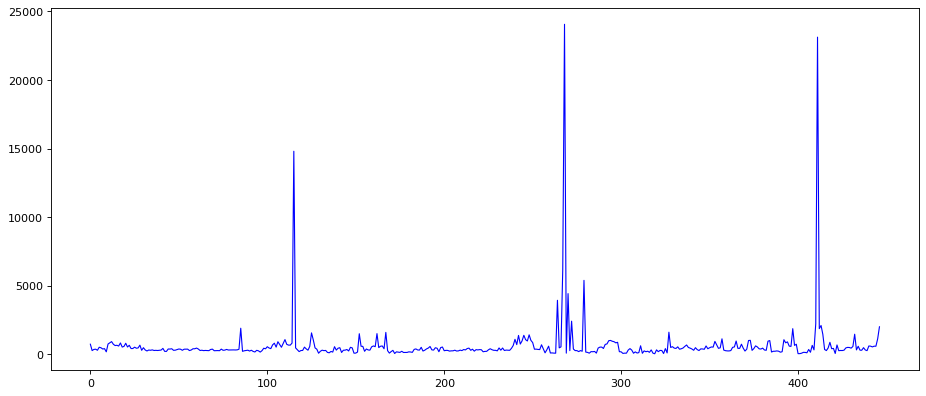

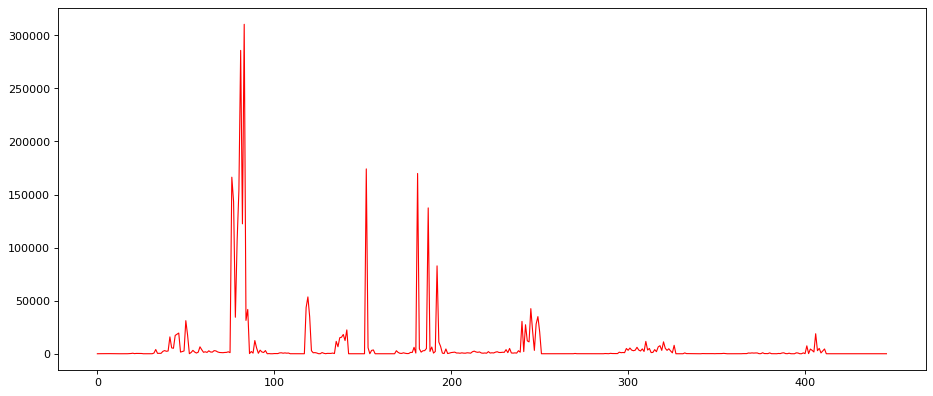

In [69]:
fig,ax = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), con, color='blue', animated=True, linewidth=1)
fig,ax2 = plt.subplots(num=None,figsize=(14,6), dpi=80, facecolor='w', edgecolor='k')
ax2.plot(range(0,size), fec, color='red', animated=True, linewidth=1)

In [ ]:
#Featured Engineering
#Let us convert our data to pandas frame. We are doing this because to train a model we need what we have to predict which is not in data. So we have to calculate water quality index which requires many steps but can be easily done using pandas and in less number of steps. Also we will able to visualize our data in tabular form more effectively.


In [70]:
df=df_clean.toPandas()
df.dtypes

STATION CODE            object
LOCATIONS               object
STATE                   object
TEMP                   float32
DO                     float32
pH                     float32
CONDUCTIVITY           float32
BOD                    float32
NITRATE_N_NITRITE_N    float32
FECAL_COLIFORM         float32
dtype: object